程式碼來源:https://www.kaggle.com/pmmilewski/pca-decomposition-and-keras-neural-network/notebook

In [2]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D,Flatten,Conv2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
test = mnist.test.images
train = mnist.train.images

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Which is 3 (3 in [2] position of the vector).


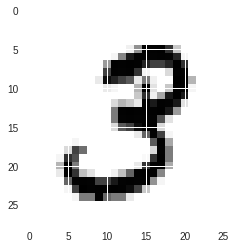

In [4]:
print(mnist.train.labels[1])
print('Which is 3 (3 in [2] position of the vector).')
plt.imshow(train[1].reshape((28,28)))

In [0]:
#PCA preprocessing前的標準化
scaler = StandardScaler()
scaler.fit(train)
X_sc_train = scaler.transform(train)
X_sc_test = scaler.transform(test)

Text(0,0.5,'Cumulative explained variance')

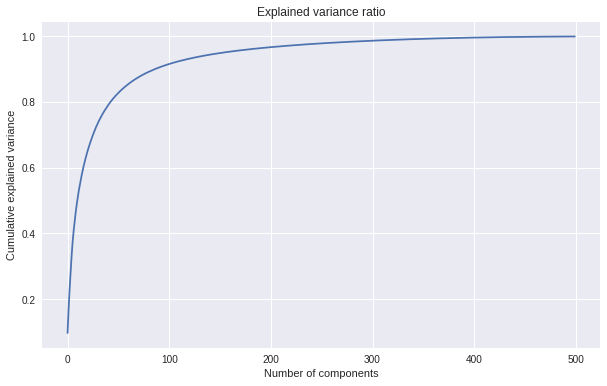

In [10]:
pca = PCA(n_components=500)
pca.fit(train)
plt.figure(figsize=(10,6))
plt.title("Explained variance ratio")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [11]:
NCOMPONENTS = 400

pca = PCA(n_components=NCOMPONENTS)
#x_pca_train是經標準化再PCA降維後的train dataset(餵給model的)
X_pca_train = pca.fit_transform(X_sc_train)
#x_pca_test是經標準化再PCA降維後的test dataset(餵給model的)
X_pca_test = pca.transform(X_sc_test)
pca_std = np.std(X_pca_train)

print(X_sc_train.shape)
print(X_pca_train.shape)

(55000, 784)
(55000, 400)


In [12]:
X_pca_test.shape

(10000, 400)

In [0]:
inv_pca = pca.inverse_transform(X_pca_train)
inv_sc = scaler.inverse_transform(inv_pca)

In [0]:
inv_pca_test = pca.inverse_transform(X_pca_test)
inv_sc_test = scaler.inverse_transform(inv_pca_test)

In [33]:
print(inv_pca_test.shape)
print(inv_sc_test.shape)

(10000, 784)
(10000, 784)


In [0]:
def side_by_side(indexes):
    org = train[indexes].reshape(28,28)
    rec = inv_sc[indexes].reshape(28,28)
    #print("O:",org,"\nR:",rec[0])
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(4,2))
    plt.imshow(pair)

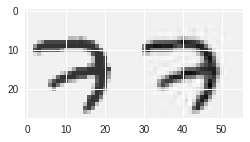

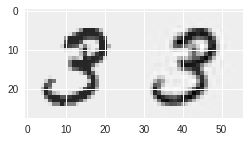

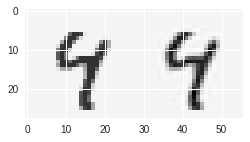

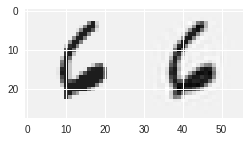

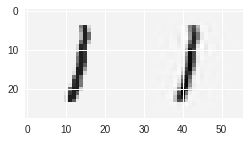

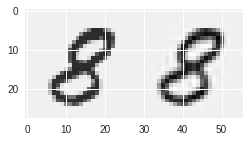

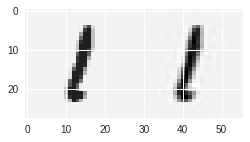

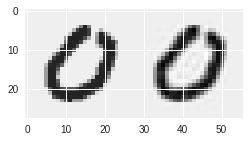

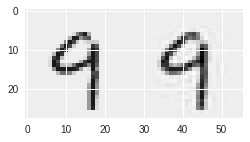

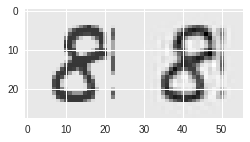

In [16]:
for index in range(0,10):
    side_by_side(index)

In [0]:
org = train.reshape(55000,28,28,1) # 原本的mnist.train.image資料集
rec = inv_sc.reshape(55000,28,28,1) # mnist.train.image經過PCA除噪音之後轉換回去的train dataset
red=X_pca_train.reshape(55000,20,20,1)# mnist.train.image經過PCA降維之後轉換回去的train dataset
red_test=X_pca_test.reshape(10000,20,20,1)# mnist.test.image經過PCA降維之後轉換回去的test dataset
rec_test=inv_sc_test.reshape(10000,28,28,1)

## PCA降維預處理搭配CNN

In [19]:
#凱華建的Keras版CNN模型
from keras.models import Sequential 
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D 
from keras.optimizers import Adamax,SGD,RMSprop,Adam,Adagrad,Nadam,Adadelta
from keras import regularizers

#---------- Build Model ---------- #
filters_1 = 32
activation_ = "relu" 
layer_CNNnum = 4
layer_FCNnum = 1
FCN_Dense = 200
loss_ = "categorical_crossentropy" 
BatchSize = 200
optimizer_ = RMSprop()
lr_ = 0.001
Epoch = 30

tStart = time.time()

model = Sequential()

# Conv 1
model.add(Conv2D(25, (3, 3), padding='same', input_shape=(20,20,1), kernel_regularizer=regularizers.l2(0.1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Conv 2 
model.add(Conv2D( 50, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
'''
# Conv 3
from keras.layers import Dropout
rate=0.35
model.add(Dropout(rate))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate))
# Conv 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate))
'''

# full NN 1 
model.add(Flatten())
model.add(Dense(200))
model.add(Activation('relu'))
# output
model.add(Dense(10))
model.add(Activation('softmax'))

#---------- Compile Model ---------- #
model.compile(loss="categorical_crossentropy",  # mse → categorical_crossentropy
              optimizer=RMSprop(),              # SGD → RMSprop
              metrics=['accuracy'])

# Model Summary 
model.summary() 


#---------- Training Model ---------- #
train_history = model.fit( red,mnist.train.labels, batch_size = BatchSize, epochs = Epoch,validation_split=0.2,verbose=2 ) 

tEnd = time.time()
duration=tEnd-tStart
print("Train Finished takes:",duration,"sec")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 25)        250       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 25)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 50)        11300     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 50)          0         
__________

In [23]:
#Ealuation
tStart1 = time.time()
scores=model.evaluate(red_test,mnist.test.labels)
tEnd1 = time.time()
duration1=tEnd1-tStart1
print("Test Finished takes:",duration1,"sec")
print("Accuuracy=",scores[1])

10000/10000 [==============================] - 3s 276us/step
Tesr Finished takes: 2.7665696144104004 sec
Accuuracy= 0.9615


PCA降維會遇到Loss壓不下來的問題,時間縮短:或許是我目前還不會搭配PCA預處理之後的參數調整  
PCA除噪音會遇到Accuracy微降的問題,時間一樣

In [0]:
#自定義的模型記錄函數
def show_train_history(train_history,train,validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title("Train History")
  plt.ylabel(train)
  plt.xlabel("Epoch")
  plt.legend(["train",'validation'],loc='upper left')

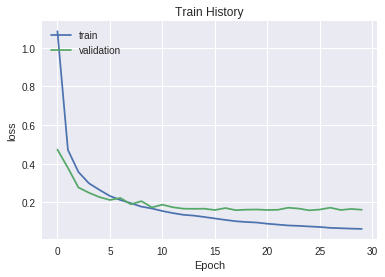

In [25]:
show_train_history(train_history,"loss","val_loss")

## CNN only

In [26]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D 
from keras.optimizers import Adamax,SGD,RMSprop,Adam,Adagrad,Nadam,Adadelta
from keras import regularizers

#---------- Build Model ---------- #
filters_1 = 32
activation_ = "relu" 
layer_CNNnum = 4
layer_FCNnum = 1
FCN_Dense = 200
loss_ = "categorical_crossentropy" 
BatchSize = 200
optimizer_ = RMSprop()
lr_ = 0.001
Epoch = 30

tStart2 = time.time()

model = Sequential()

# Conv 1
model.add(Conv2D(25, (3, 3), padding='same', input_shape=(28,28,1),
                kernel_regularizer=regularizers.l2(0.1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Conv 2 
model.add(Conv2D( 50, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
'''
# Conv 3
from keras.layers import Dropout
rate=0.35
model.add(Dropout(rate))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate))
# Conv 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate))
'''

# full 1
model.add(Flatten())
model.add(Dense(200))
model.add(Activation('relu'))
# output
model.add(Dense(10))
model.add(Activation('softmax'))

#---------- Compile Model ---------- #
model.compile(loss="categorical_crossentropy",  # mse → categorical_crossentropy
              optimizer=RMSprop(),              # SGD → RMSprop
              metrics=['accuracy'])

# Model Summary 
model.summary() 


#---------- Training Model ---------- #
train_history_1 = model.fit( org,mnist.train.labels, batch_size = BatchSize, epochs = Epoch,validation_split=0.2,verbose=2 ) 

tEnd2 = time.time()
duration2=tEnd2-tStart2
print("Train Finished takes:",duration2,"sec")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 25)        250       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 25)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 25)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        11300     
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 50)          0         
__________

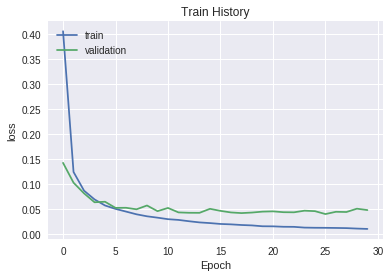

In [27]:
show_train_history(train_history_1,"loss","val_loss")

In [29]:
#Ealuation
test1=test.reshape(10000,28,28,1)
tStart3 = time.time()
scores=model.evaluate(test1,mnist.test.labels)
tEnd3 = time.time()
duration3=tEnd3-tStart3
print("Test Finished takes:",duration3,"sec")
print("Accuuracy=",scores[1])

10000/10000 [==============================] - 5s 459us/step
Test Finished takes: 4.592509508132935 sec
Accuuracy= 0.991


##PCA預處理除噪音搭配CNN

In [30]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D 
from keras.optimizers import Adamax,SGD,RMSprop,Adam,Adagrad,Nadam,Adadelta
from keras import regularizers

#---------- Build Model ---------- #
filters_1 = 32
activation_ = "relu" 
layer_CNNnum = 4
layer_FCNnum = 1
FCN_Dense = 200
loss_ = "categorical_crossentropy" 
BatchSize = 200
optimizer_ = RMSprop()
lr_ = 0.001
Epoch = 30

tStart4 = time.time()

model = Sequential()

# Conv 1
model.add(Conv2D(25, (3, 3), padding='same', input_shape=(28,28,1),
                kernel_regularizer=regularizers.l2(0.1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Conv 2 
model.add(Conv2D( 50, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
'''
# Conv 3
from keras.layers import Dropout
rate=0.35
model.add(Dropout(rate))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate))
# Conv 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate))
'''

# full 1
model.add(Flatten())
model.add(Dense(200))
model.add(Activation('relu'))
# output
model.add(Dense(10))
model.add(Activation('softmax'))

#---------- Compile Model ---------- #
model.compile(loss="categorical_crossentropy",  # mse → categorical_crossentropy
              optimizer=RMSprop(),              # SGD → RMSprop
              metrics=['accuracy'])

# Model Summary 
model.summary() 


#---------- Training Model ---------- #
train_history2 = model.fit( rec,mnist.train.labels, batch_size = BatchSize, epochs = Epoch,validation_split=0.2,verbose=2 ) 

tEnd4 = time.time()
duration4=tEnd4-tStart4
print("Train Finished takes:",duration4,"sec")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 25)        250       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 25)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 25)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 50)        11300     
_________________________________________________________________
activation_10 (Activation)   (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 50)          0         
__________

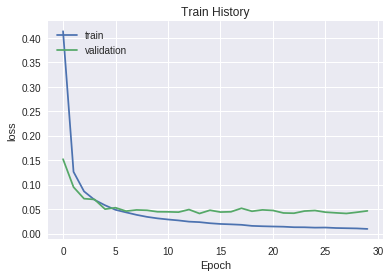

In [31]:
show_train_history(train_history2,"loss","val_loss")

In [37]:
#Ealuation
tStart5 = time.time()
scores=model.evaluate(rec_test,mnist.test.labels)
tEnd5 = time.time()
duration5=tEnd5-tStart5
print("Test Finished takes:",duration5,"sec")
print("Accuuracy=",scores[1])

10000/10000 [==============================] - 5s 506us/step
Test Finished takes: 5.064165830612183 sec
Accuuracy= 0.9915


## 參考別人的CNN------------------------------------------------------------------------------------------------------------

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import Dropout

tStart = time.time()

model = Sequential()

from keras import regularizers

# Conv 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28,28,1),
                kernel_regularizer=regularizers.l2(0.1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Conv 2 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Conv 3
rate=0.35
model.add(Dropout(rate))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate))
# Conv 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate))

# full 1
model.add(Flatten())
model.add(Dense(200))
model.add(Activation('relu'))
# output
model.add(Dense(10))
model.add(Activation('softmax'))

#---------- Compile Model ---------- #
from keras.optimizers import Adamax,SGD,RMSprop,Adam,Adagrad,Nadam,Adadelta

model.compile(loss="categorical_crossentropy",  # mse → categorical_crossentropy
              optimizer=RMSprop(),              # SGD → RMSprop
              metrics=['accuracy'])

# Model Summary 
model.summary() 

#---------- Training Model ---------- #
#model.fit(x_train, y_train, batch_size=200, epochs=7)
train_history_ori = model.fit( org,mnist.train.labels, batch_size = 200, epochs = Epoch,validation_split=0.2,verbose=2 ) 

#time
tEnd = time.time()
duration=tEnd-tStart
print("Train Finished takes:",duration,"sec")
# 142.16875290870667 sec, acc 0.9895
'''
scores=model.evaluate(X_pca_test,mnist.test.labels)
print("Accuuracy=",scores[1])
'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_25 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_26 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 64)          0         
__________

'\nscores=model.evaluate(X_pca_test,mnist.test.labels)\nprint("Accuuracy=",scores[1])\n'

### 結論: 若先做PCA後再放入CNN所需要的時間是CNN的一半，準度只下降不到0.002

## NN--------------------------------------------------------------------------------------------------------------------

In [0]:
tStart = time.time()
model = Sequential()
layers = 1
units = 128
#用2層fully connect全連接層(不含Input和Output層)做NN
model.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
#加bias
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    #加bias
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
train_history=model.fit(X_pca_train,mnist.train.labels, epochs=100, batch_size=100, verbose=2,validation_split=0.2)
tEnd = time.time()
duration=tEnd-tStart
print("Train Finished takes:",duration,"sec")

Train on 44000 samples, validate on 11000 samples
Epoch 1/100
 - 3s - loss: 1.0601 - categorical_accuracy: 0.7124 - val_loss: 0.2575 - val_categorical_accuracy: 0.9277
Epoch 2/100
 - 2s - loss: 0.3709 - categorical_accuracy: 0.8936 - val_loss: 0.1822 - val_categorical_accuracy: 0.9457
Epoch 3/100
 - 2s - loss: 0.2584 - categorical_accuracy: 0.9214 - val_loss: 0.1565 - val_categorical_accuracy: 0.9547
Epoch 4/100
 - 2s - loss: 0.2069 - categorical_accuracy: 0.9377 - val_loss: 0.1397 - val_categorical_accuracy: 0.9586
Epoch 5/100
 - 3s - loss: 0.1708 - categorical_accuracy: 0.9481 - val_loss: 0.1258 - val_categorical_accuracy: 0.9635
Epoch 6/100
 - 2s - loss: 0.1457 - categorical_accuracy: 0.9555 - val_loss: 0.1223 - val_categorical_accuracy: 0.9659
Epoch 7/100
 - 2s - loss: 0.1269 - categorical_accuracy: 0.9610 - val_loss: 0.1127 - val_categorical_accuracy: 0.9693
Epoch 8/100
 - 2s - loss: 0.1113 - categorical_accuracy: 0.9652 - val_loss: 0.1129 - val_categorical_accuracy: 0.9697
Epoch 

Epoch 70/100
 - 2s - loss: 0.0111 - categorical_accuracy: 0.9970 - val_loss: 0.1852 - val_categorical_accuracy: 0.9761
Epoch 71/100
 - 2s - loss: 0.0104 - categorical_accuracy: 0.9971 - val_loss: 0.1796 - val_categorical_accuracy: 0.9765
Epoch 72/100
 - 2s - loss: 0.0107 - categorical_accuracy: 0.9968 - val_loss: 0.1911 - val_categorical_accuracy: 0.9771
Epoch 73/100
 - 2s - loss: 0.0108 - categorical_accuracy: 0.9970 - val_loss: 0.1970 - val_categorical_accuracy: 0.9755
Epoch 74/100
 - 2s - loss: 0.0112 - categorical_accuracy: 0.9969 - val_loss: 0.1889 - val_categorical_accuracy: 0.9765
Epoch 75/100
 - 2s - loss: 0.0118 - categorical_accuracy: 0.9968 - val_loss: 0.1946 - val_categorical_accuracy: 0.9752
Epoch 76/100
 - 2s - loss: 0.0122 - categorical_accuracy: 0.9966 - val_loss: 0.1951 - val_categorical_accuracy: 0.9757
Epoch 77/100
 - 3s - loss: 0.0123 - categorical_accuracy: 0.9964 - val_loss: 0.1911 - val_categorical_accuracy: 0.9761
Epoch 78/100
 - 2s - loss: 0.0097 - categorical_

In [0]:
show_train_history(train_history,"categorical_accuracy","val_categorical_accuracy")

KeyError: 'categorical_accuracy'

In [0]:
scores=model.evaluate(X_pca_test,mnist.test.labels)
print()
print("Accuuracy=",scores[1])

10000/10000 [==============================] - 1s 77us/step

Accuuracy= 0.9735


In [0]:
prediction=model.predict_classes(X_pca_test)

In [0]:
prediction

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               51328     
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 69,130
Trainable params: 69,130
Non-trainable params: 0
_________________________________________________________________
None
